In [277]:
import numpy as np
from smt.surrogate_models import KRG, RBF
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

In [278]:
generating_df = pd.read_csv('monte_carlo_10000.csv').drop(columns=['sample'])
training_df = pd.read_csv('training_data_bending.csv')

In [279]:
X = training_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
Y = training_df[['mean_force']].values

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
generating_array = generating_df[['outer_wall_thickness', 'inside_wall_side_thickness', 'inside_wall_middle_thickness', 'height', 'width', 'sigma0', 'youngs']].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
generating_array_scaled = scaler.transform(generating_array)
X_val = scaler.transform(X_val)

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0002389
      Initializing linear solver - done. Time (sec):  0.0003290
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000279
      Solving linear system (col. 0) - done. Time (sec):  0.0000381
   Training - done. Time (sec):  0.0018160
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Pre

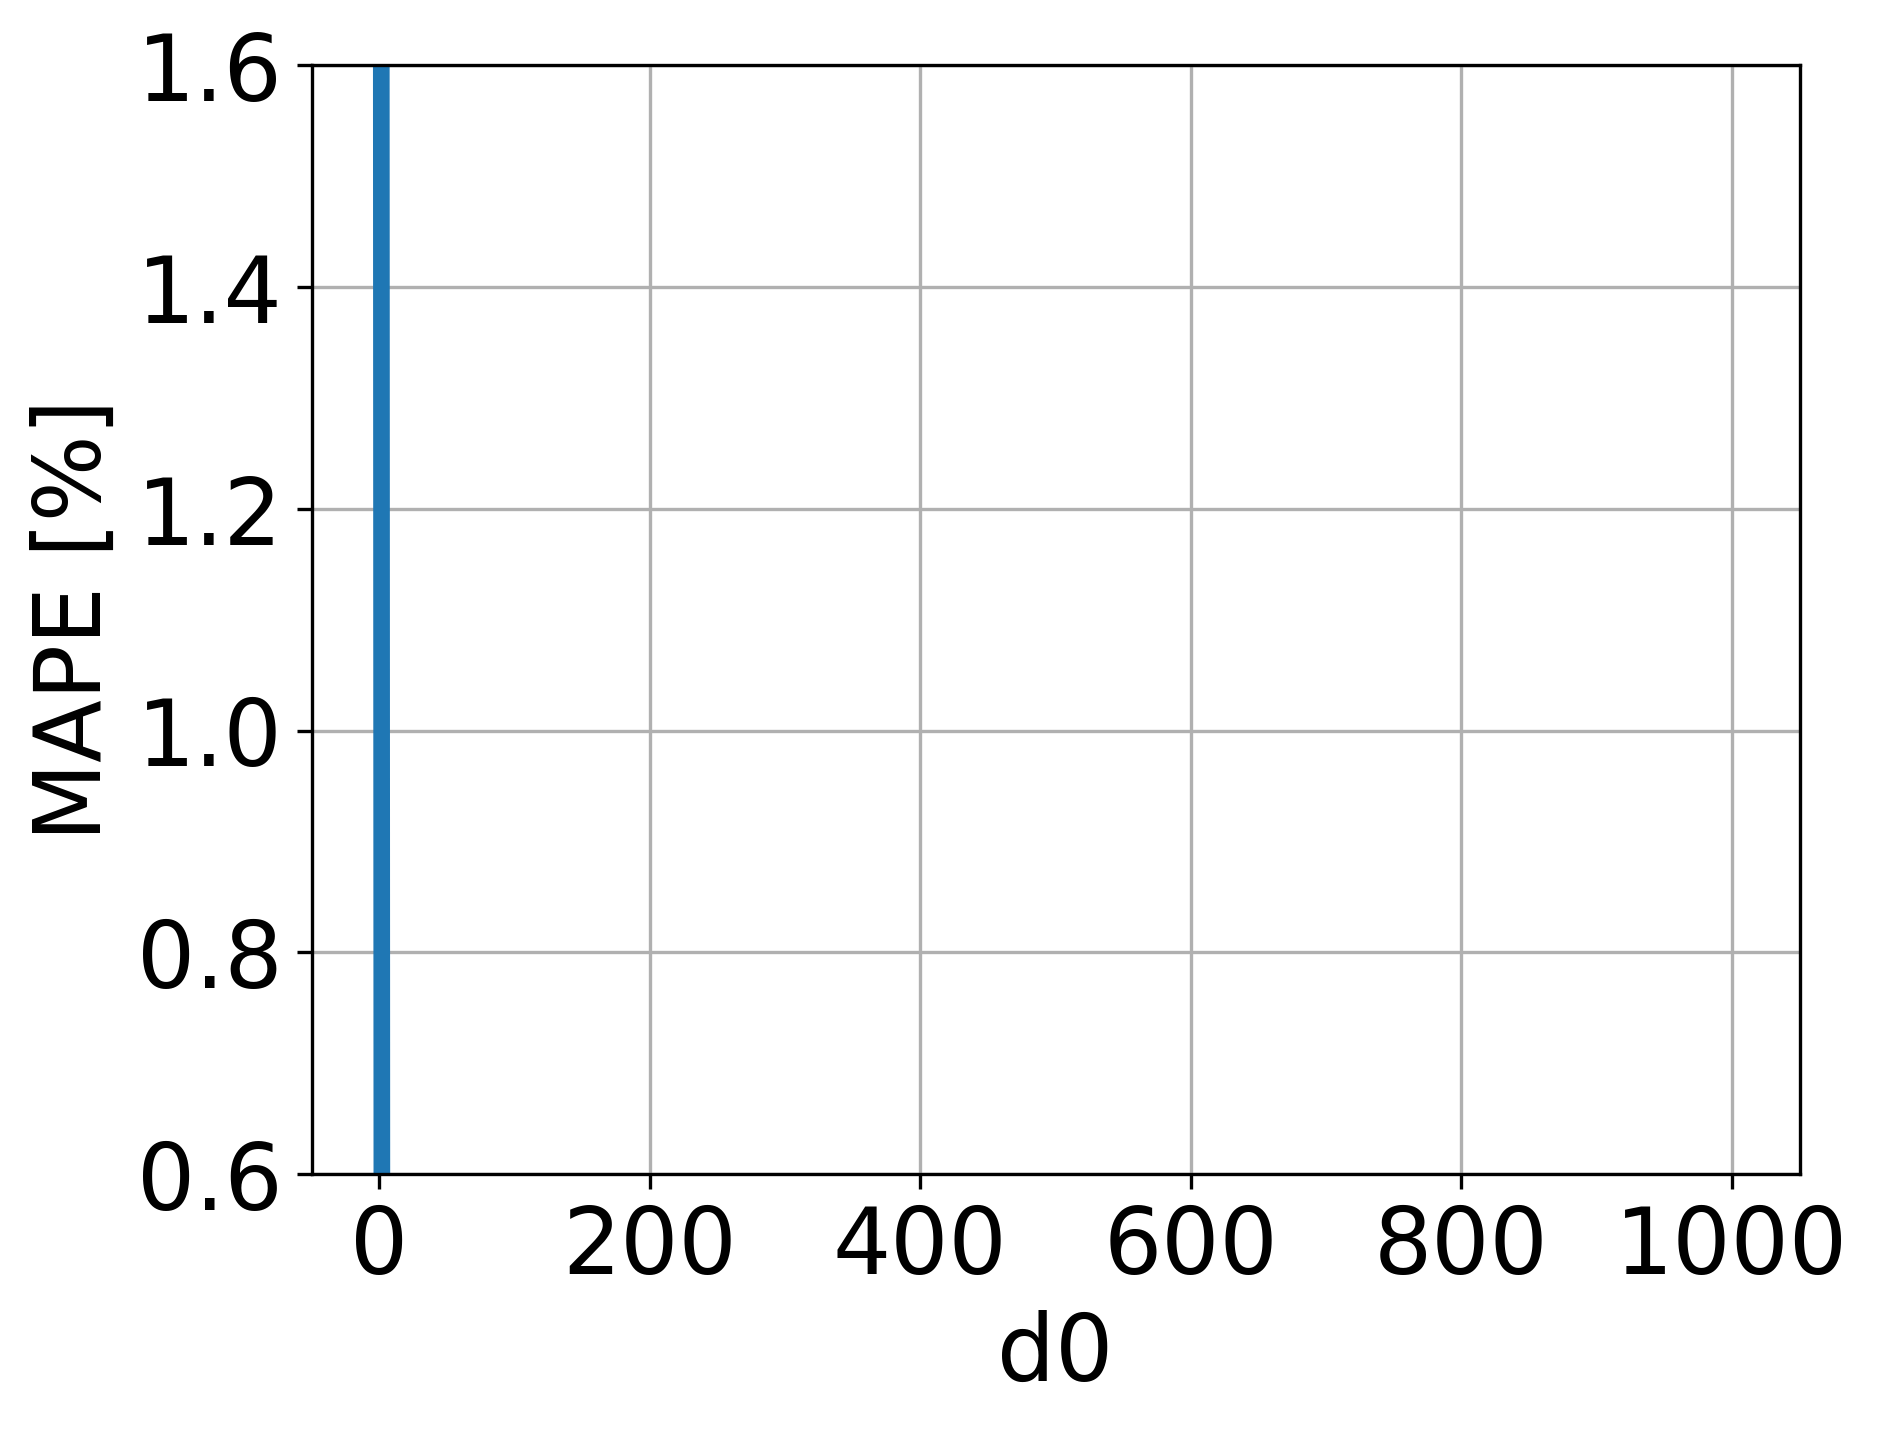

In [280]:
d0_values = np.linspace(0.0001, 1000, 1000)
results = {}

for i in range(len(d0_values)):
    RBF_model = RBF(d0=d0_values[i])
    RBF_model.set_training_values(X_train, Y_train)
    RBF_model.train()
    Y_pred = RBF_model.predict_values(X_val)
    mape = mean_absolute_percentage_error(Y_val, Y_pred)
    results[d0_values[i]] = mape*100

xmax = min(results, key=results.get)
ymax = results[xmax]

plt.figure(dpi=300)
plt.ylim(0.6, 1.6)
plt.plot(results.keys(), results.values(), lw=4)
plt.plot(min(results, key=results.get), min(results.values()), 'ro', markersize=12)
plt.annotate(f'({xmax:.0f}, {ymax:.2f}%)', xy=(xmax, ymax), xytext=(xmax+18, ymax-0.1), fontsize=22)
plt.xlabel('d0', fontsize=22)
plt.ylabel('MAPE [%]', fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid()
plt.show()

In [281]:
RBF_model = RBF(d0=min(results, key=results.get))
RBF_model.set_training_values(X_train, Y_train)
RBF_model.train()

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 80
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (80 x 80 mtx) ...
         Performing LU fact. (80 x 80 mtx) - done. Time (sec):  0.0004623
      Initializing linear solver - done. Time (sec):  0.0004909
      Solving linear system (col. 0) ...
         Back solving (80 x 80 mtx) ...
         Back solving (80 x 80 mtx) - done. Time (sec):  0.0000331
      Solving linear system (col. 0) - done. Time (sec):  0.0000432
   Training - done. Time (sec):  0.0017319


In [282]:
predicted_values = RBF_model.predict_values(generating_array_scaled)
Y_pred = RBF_model.predict_values(X_val)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 10000
   
   Predicting ...
   Predicting - done. Time (sec):  0.0252869
   
   Prediction time/pt. (sec) :  0.0000025
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 20
   
   Predicting ...
   Predicting - done. Time (sec):  0.0104358
   
   Prediction time/pt. (sec) :  0.0005218
   


In [283]:
mape = mean_absolute_percentage_error(Y_val, Y_pred)
print("MAPE, for RBF:", format(round(float(mape), 4)*100,'.2f'), "%")

MAPE, for RBF: 0.26 %


In [284]:
# adding the predicted values to the dataframe
generating_df['predicted_mean_force'] = predicted_values
generating_df.head()

,outer_wall_thickness,inside_wall_side_thickness,inside_wall_middle_thickness,height,width,sigma0,youngs,predicted_mean_force
0,2.76,1.96,1.67,75.29,127.80,278.56,73252.4,31.101540
1,2.84,2.29,1.39,75.81,127.68,277.41,65871.1,31.834382
2,2.63,2.21,1.53,75.94,128.37,289.44,65737.1,29.937552
3,2.52,1.85,1.52,75.57,127.39,285.63,63937.5,26.567989
4,2.78,1.97,1.52,75.45,128.33,282.14,71745.5,31.173928


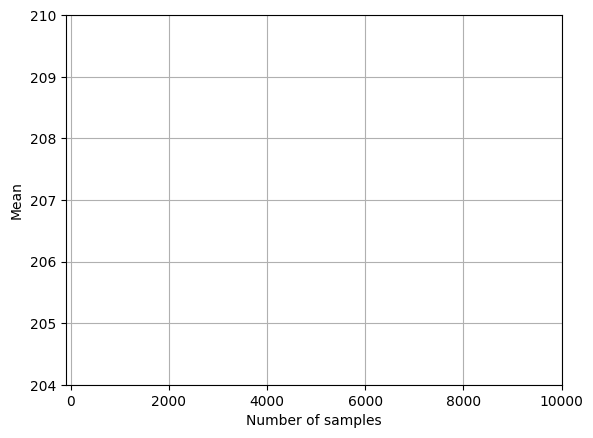

In [285]:
# Check convergence of mean
mean = np.zeros(len(generating_df))
for i in range(len(generating_df)):
    mean[i] = np.mean(generating_df['predicted_mean_force'][:i+1])

plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999]), color='r', linewidth=2)
#plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999])*1.001, color='r', linewidth=1)
#plt.axhline(y=np.mean(generating_df['predicted_mean_force'][:9999])*0.999, color='r', linewidth=1)

plt.plot(mean)
plt.xlabel('Number of samples')
plt.ylabel('Mean')
plt.ylim(204, 210)
plt.xlim(-100, 10000)
plt.grid()

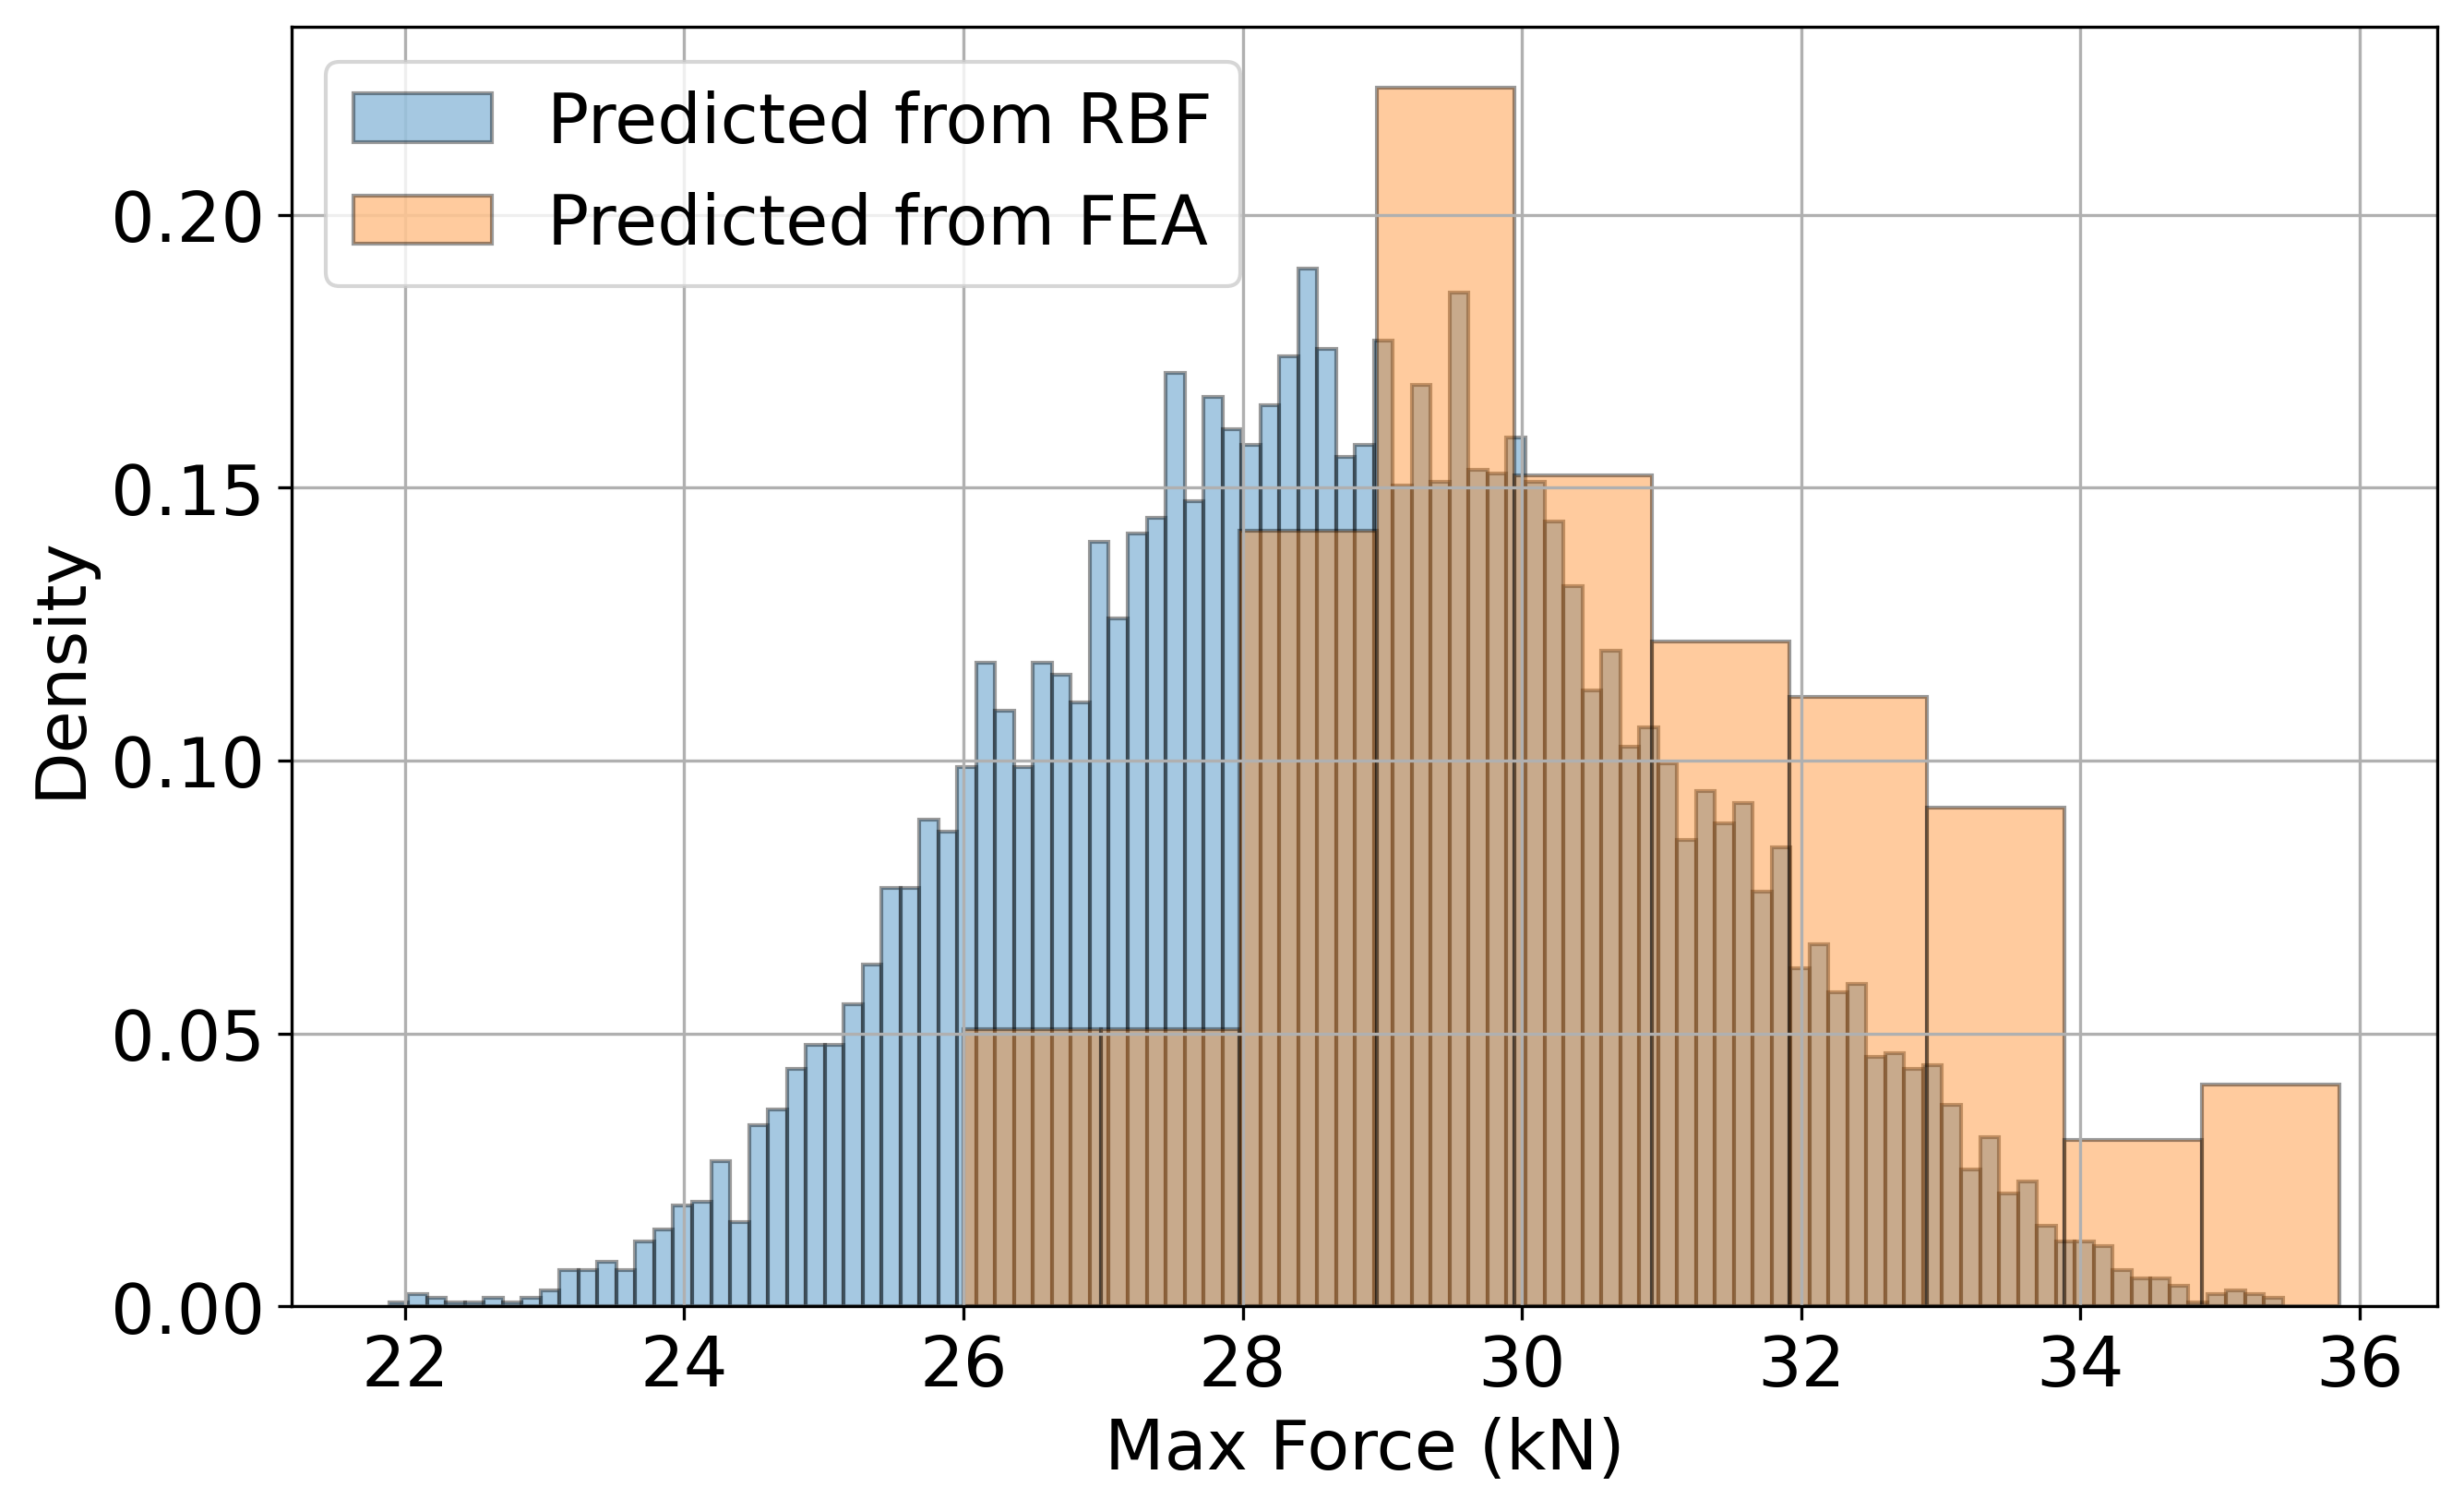

In [286]:
plt.figure(figsize=(10, 6), dpi=300)
plt.hist(
    x=generating_df['predicted_mean_force'],
    bins=100,
    label='Predicted from RBF',
    alpha=0.4, 
    edgecolor='black',
    linewidth=1,
    density=True
    )

plt.hist(
    x=training_df['max_force'], 
    bins=10, 
    label='Predicted from FEA', 
    alpha=0.4, 
    edgecolor='black', 
    linewidth=1,
    density=True
    )
plt.grid()
plt.xlabel('Max Force (kN)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.show()

<h1>Changing amount of data

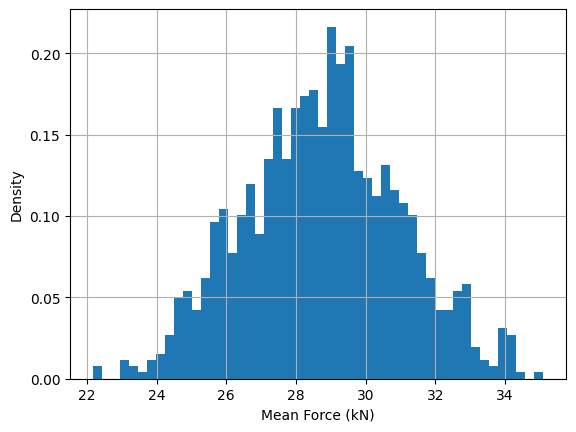

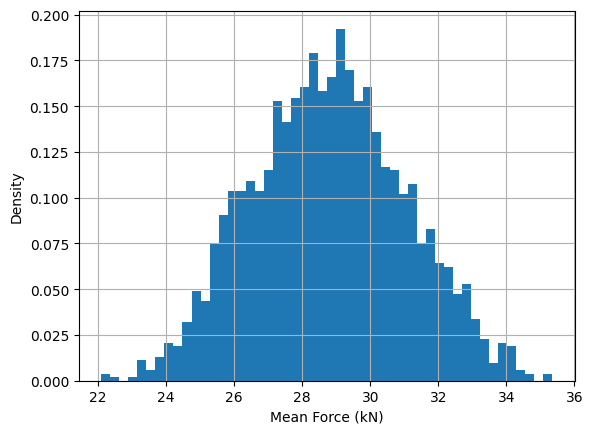

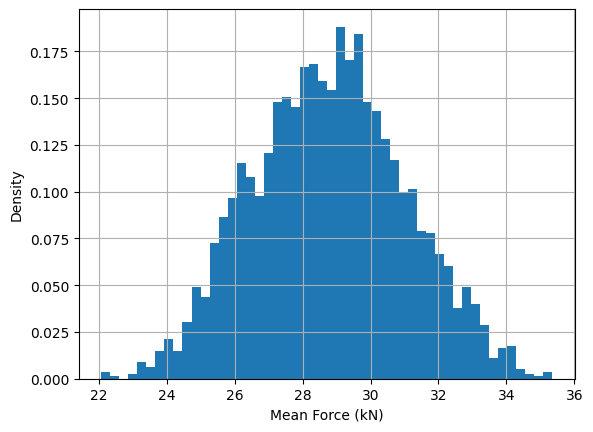

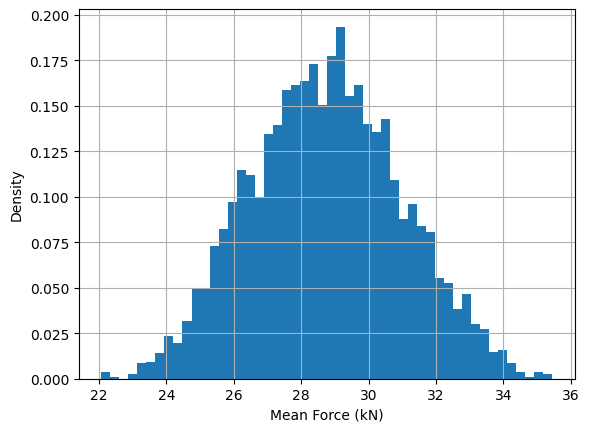

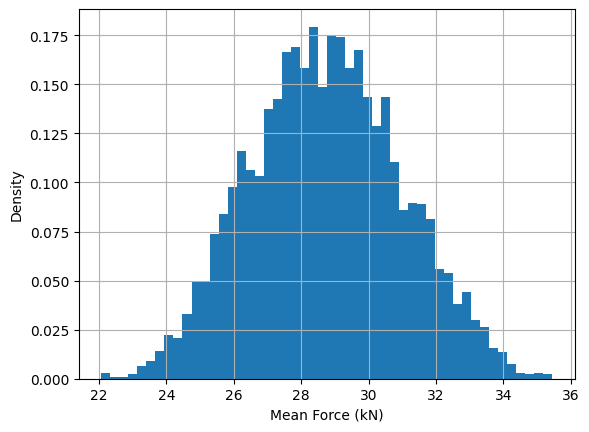

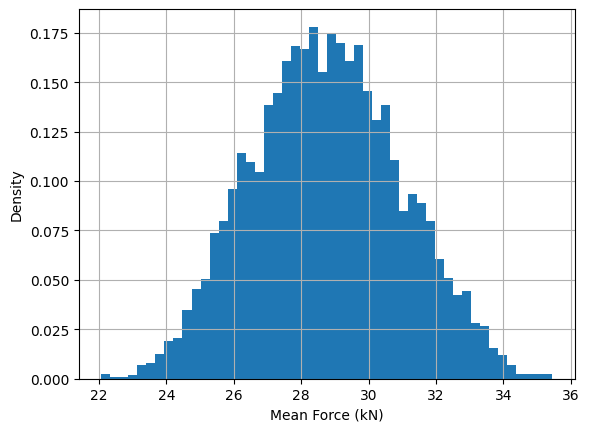

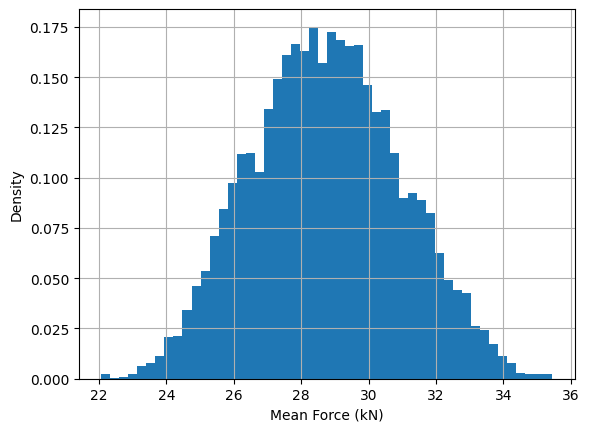

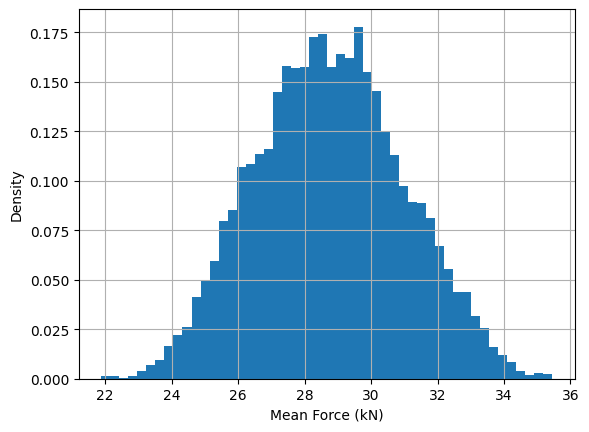

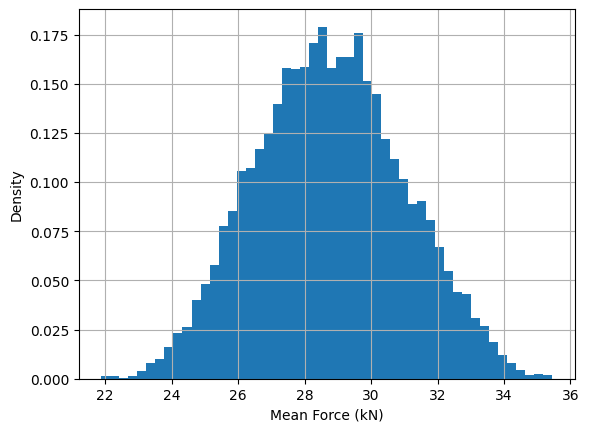

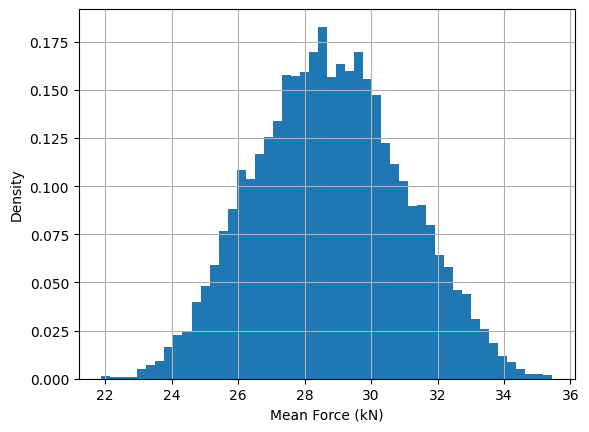

In [287]:
for i in range(10):
    plt.hist(
        x=generating_df['predicted_mean_force'][:1000*(i+1)],
        bins=50,
        label='Predicted',
        density=True,
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()

<h1>Changing number of boxes

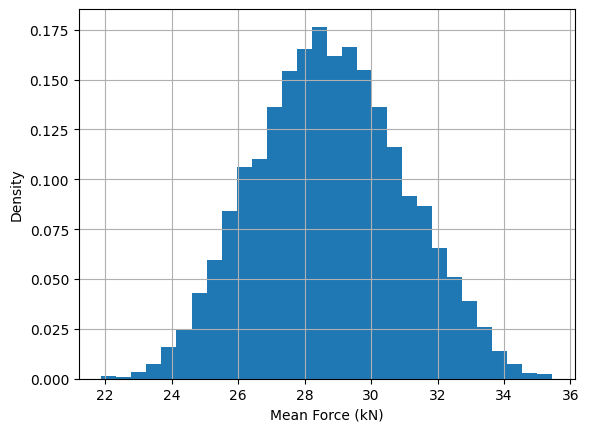

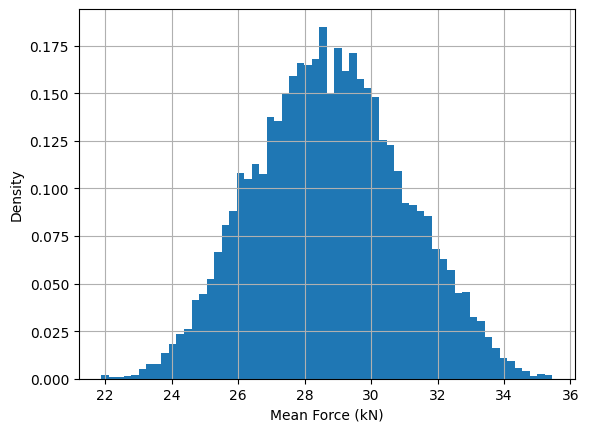

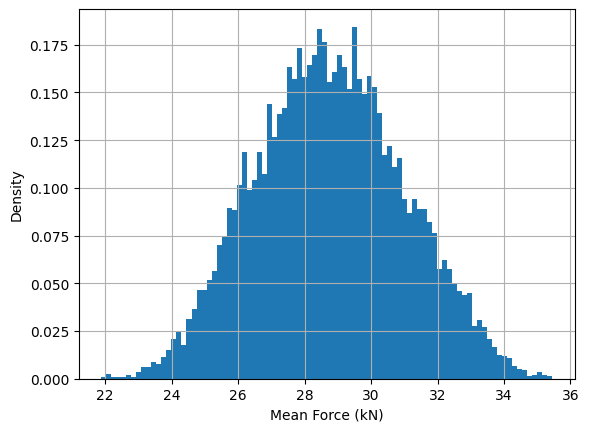

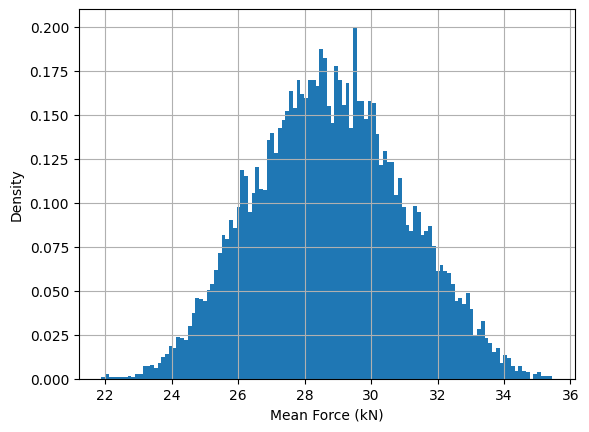

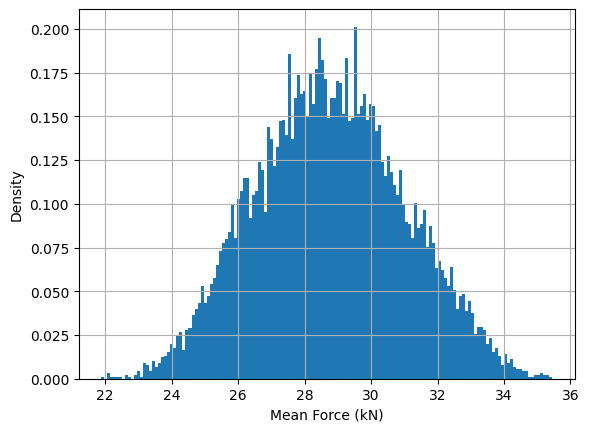

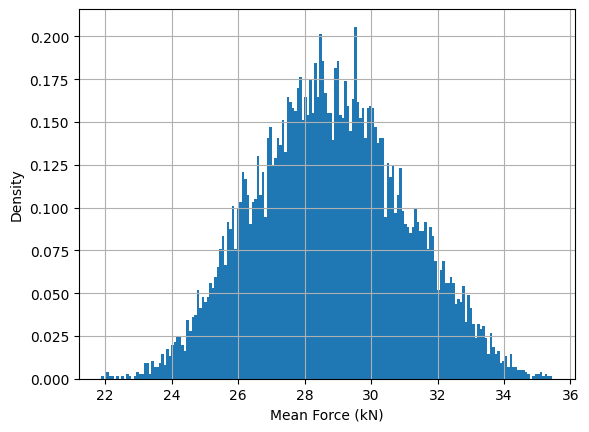

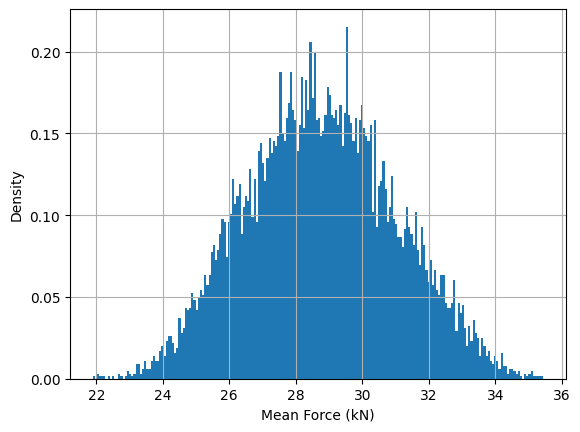

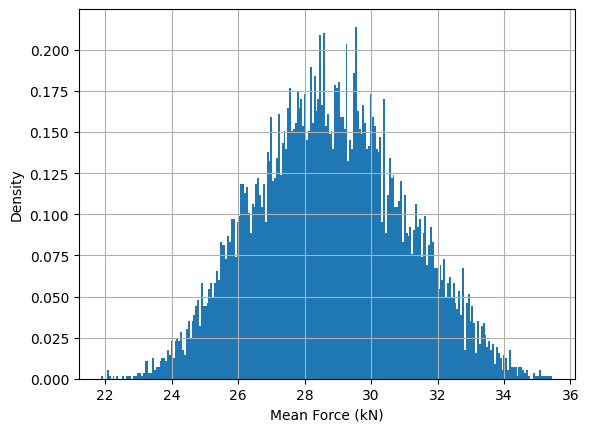

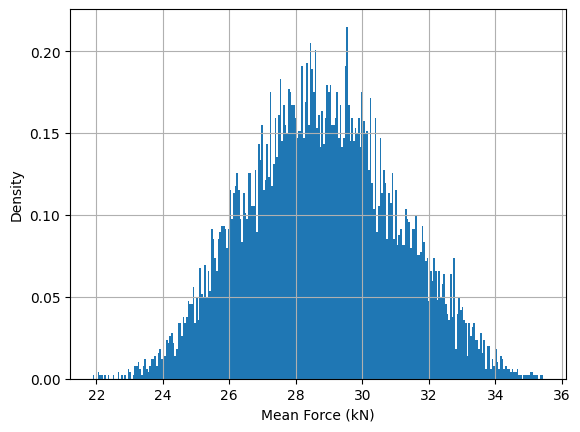

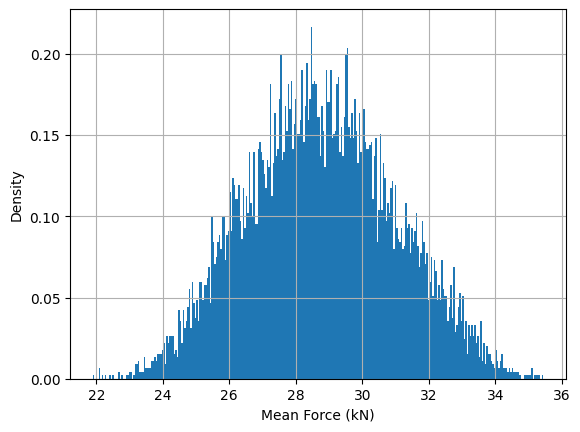

In [288]:
for i in range(10):
    plt.hist(
        x=generating_df['predicted_mean_force'],
        bins=30*(i+1),
        label='Predicted',
        density=True
    )
    plt.grid()
    plt.xlabel('Mean Force (kN)')
    plt.ylabel('Density')
    plt.show()